In [1]:
from importlib import reload
from os.path import join
from collections import defaultdict
import sys
import numpy as np
import cv2
cv2.setNumThreads(1)
import os
import itertools

In [2]:
import ipywidgets
from IPython.display import display, clear_output
from matplotlib import pyplot

In [3]:
from datasets.dshdf5pose import Hdf5PoseDataset
import datatransformation
import neuralnets.models
import neuralnets.modelcomponents
import vis
import utils
import train

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as tf
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms

In [5]:
net = neuralnets.models.MobilnetV1WithPointHead()
state_dict = torch.load( join('..','model_files','best_MobilnetV1WithPointHead.ckpt'))
neuralnets.modelcomponents.clear_denormals_inplace(state_dict)
net.load_state_dict(state_dict)
net.cuda()
net.eval()

Denormals or zeros:
convnet.dw6.bn_dw.running_mean          :          2 (0.1953125%)
convnet.dw6.bn_dw.running_var           :          2 (0.1953125%)


MobilnetV1WithPointHead(
  (convnet): MobileNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dw2_1): DepthWiseBlock(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn_dw): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv_sep): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_sep): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (dw2_2): DepthWiseBlock(
      (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn_dw): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv_sep): Conv2d(64, 128, kernel_size=(1, 1), stride

In [6]:
inputsize = net.input_resolution
datadir = os.environ['DATADIR']

testpreprocess = [
    datatransformation.ApplyRoi(),
    datatransformation.Rescale(inputsize+1),
    datatransformation.CenterCrop(inputsize),
]
normalize_and_tensor = [
    datatransformation.Normalize(monochrome=True),
    datatransformation.ToTensor()
]


ds_test_biwi = Hdf5PoseDataset(join(datadir,'biwi.h5'), shuffle=True, subset=None, transform=transforms.Compose([
    datatransformation.InjectZeroKeypoints3d(),
    datatransformation.InjectPoseEnable(),
    *testpreprocess,
    *normalize_and_tensor
]))

# Maybe not the best way to pick a test set. However, the h5 dataset is shuffled so getting the first 400 items is 
# still a idependent sample from the overall dataet. It should also be deterministically reproducible since
# the h5 is generated using a fixed seed for the shuffeling.
ds_test_aflw = Hdf5PoseDataset(join(datadir,'aflw2k.h5'), shuffle=False, subset=slice(400), transform=transforms.Compose([
    datatransformation.InjectPt3d68Enable(),
    datatransformation.InjectPoseEnable(),
    *testpreprocess,
    *normalize_and_tensor
]))

In [7]:
aflw_loader = DataLoader(ds_test_aflw, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5)

biwi_loader = DataLoader(ds_test_biwi, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5)

In [8]:
def iterate_predictions(loader, net):
    for batch in loader:
        with torch.no_grad():
            preds = net.inference(batch['image'].cuda())
            preds = { k:v.cpu() for k,v in preds.items() }
        for sample, pred in zip(utils.undo_collate(batch), utils.undo_collate(preds)):
                yield vis.unnormalize_sample_to_numpy(sample, pred)

### Visualize AFLW

<IPython.core.display.Javascript object>


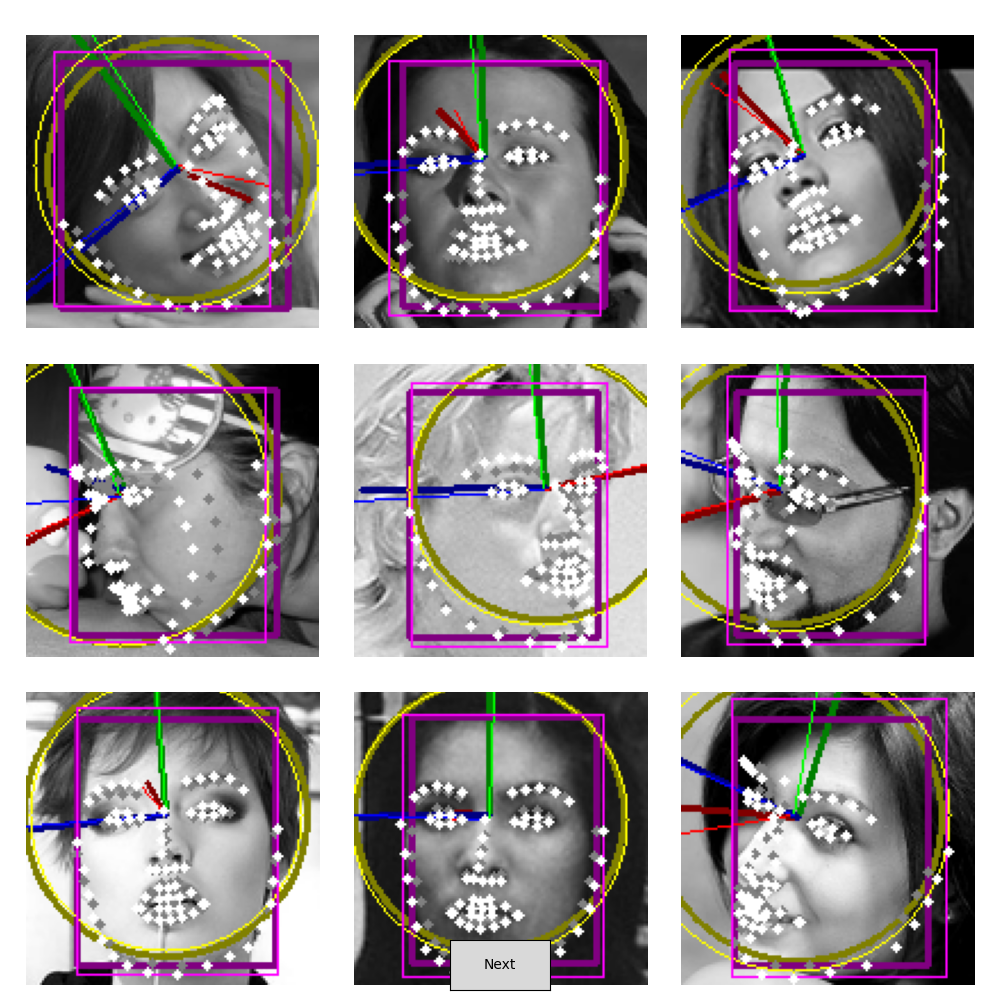

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7fca1f0fe2d0>)

In [9]:
%matplotlib notebook
vis.matplotlib_plot_iterable(iterate_predictions(aflw_loader, net), vis.draw_prediction)

### Visualize AFLW
Can only check if the keypoints look all right. Otherwise nothing can be done currently due to the different coordinate frame.

<IPython.core.display.Javascript object>


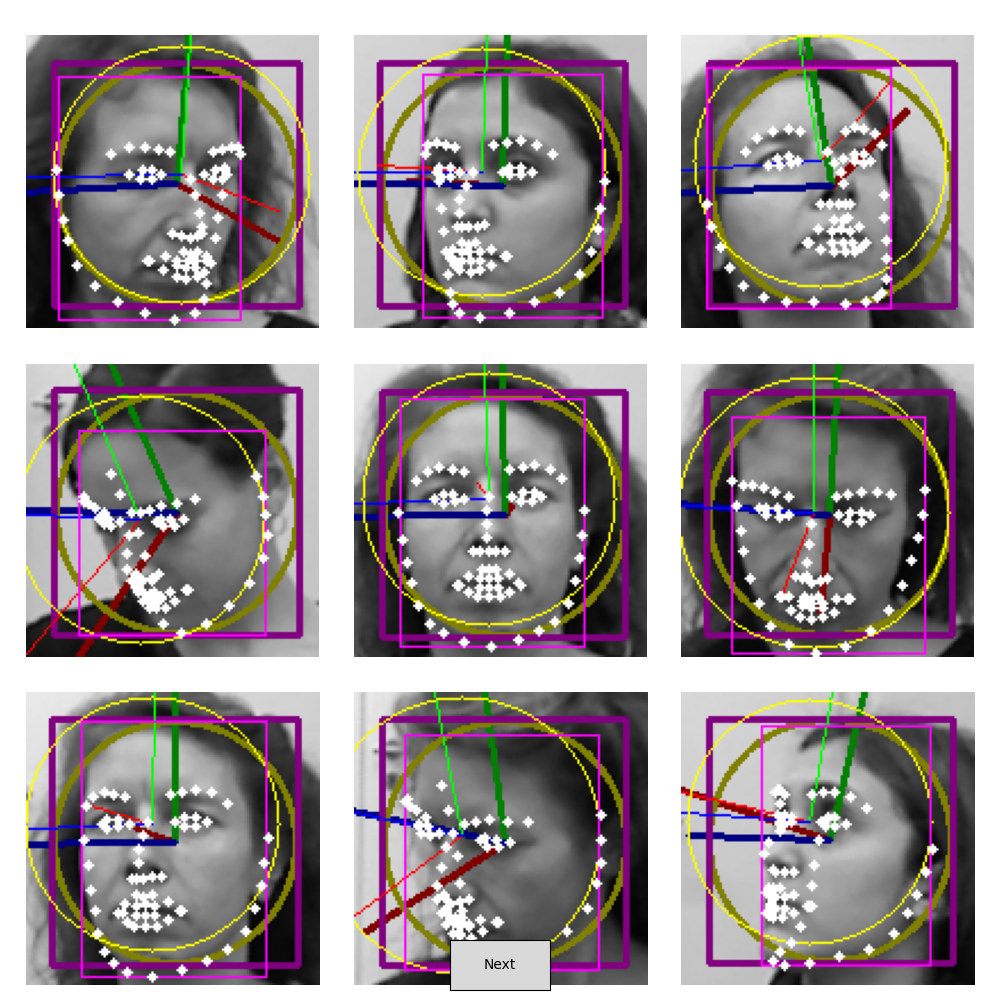

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7fca11de56d0>)

In [10]:
vis.matplotlib_plot_iterable(iterate_predictions(biwi_loader, net), vis.draw_prediction)

In [11]:
def report(net, loader):
    poseerrs = train.metrics_over_full_dataset(
        net, 
        [ train.PoseErr() ], 
        loader)
    e_rot, e_posx, e_posy, e_size = np.array(poseerrs).T
    rmse_pos = np.sqrt(np.average(np.sum(np.square(np.hstack([e_posx, e_posy])), axis=1), axis=0))
    rmse_size = np.sqrt(np.average(np.square(e_size)))
    print (f"Average angular error: {np.average(e_rot)*180/np.pi:.03f}°")
    print (f"Position RMSE: {rmse_pos*100:.03f}%")
    print (f"Size RMSE: {rmse_size*100:.03f}%")
    

def rot_err(preds, batch):
    errs = train.PoseErr()(preds, batch)
    return errs[:,0] # Rotation

def pose_err(preds, batch):
    errs = train.PoseErr()(preds, batch)
    return np.amax(errs[:,1:], axis=1)

def display_worst(items):
    def iterate():
        for v, sample, pred in items:
            yield vis.unnormalize_sample_to_numpy(sample, pred)
    
    return vis.matplotlib_plot_iterable(iterate(), vis.draw_prediction)    

In [12]:
net.eval()
report(net, aflw_loader)

Average angular error: 5.965°
Position RMSE: 3.941%
Size RMSE: 5.290%


Previously:
```
Average angular error: 5.965°
Position RMSE: 3.941%
Size RMSE: 5.290%
```
The results unfortunately depend quite strongly on the choice of test set as there are some pretty hard cases in the overall dataset which can spoil the statistics if they make it into the test set.

<IPython.core.display.Javascript object>


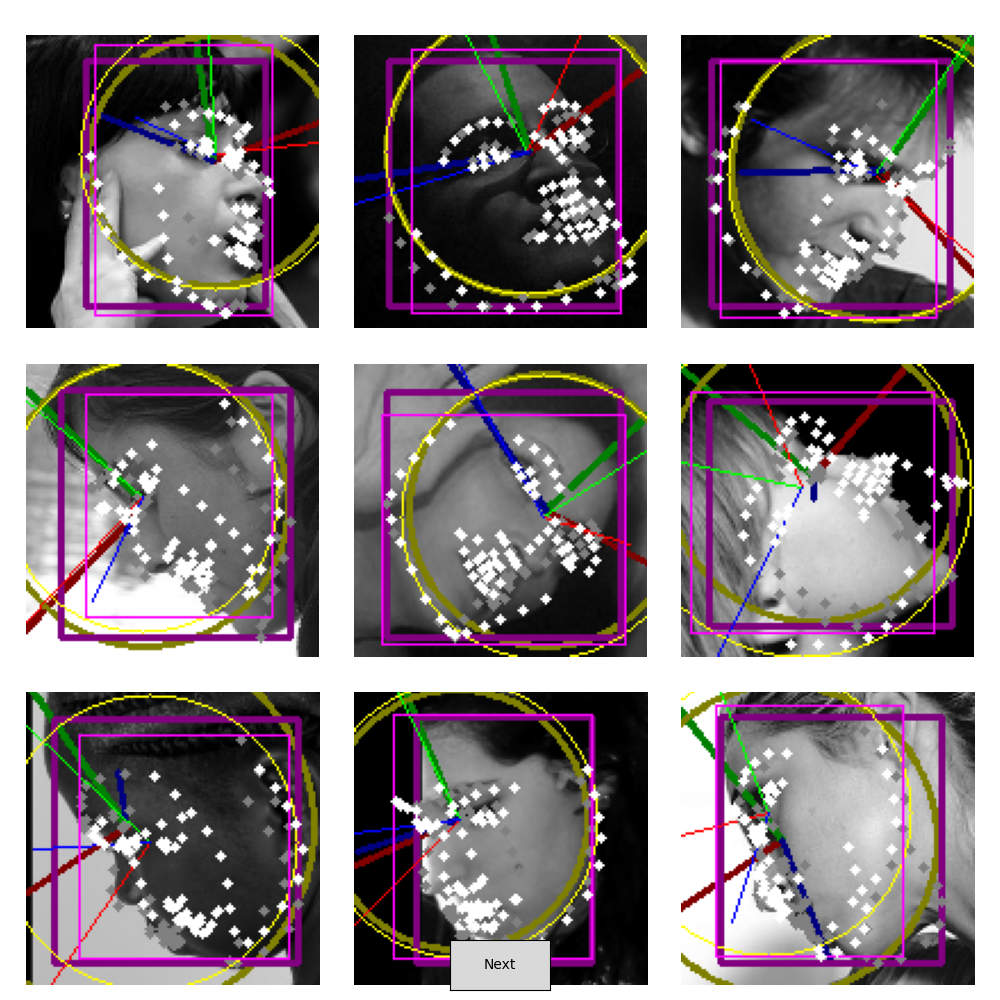

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7fca10238390>)

In [13]:
worst = train.k_worst_over_dataset(net, aflw_loader, rot_err, 9)
display_worst(worst)

<IPython.core.display.Javascript object>


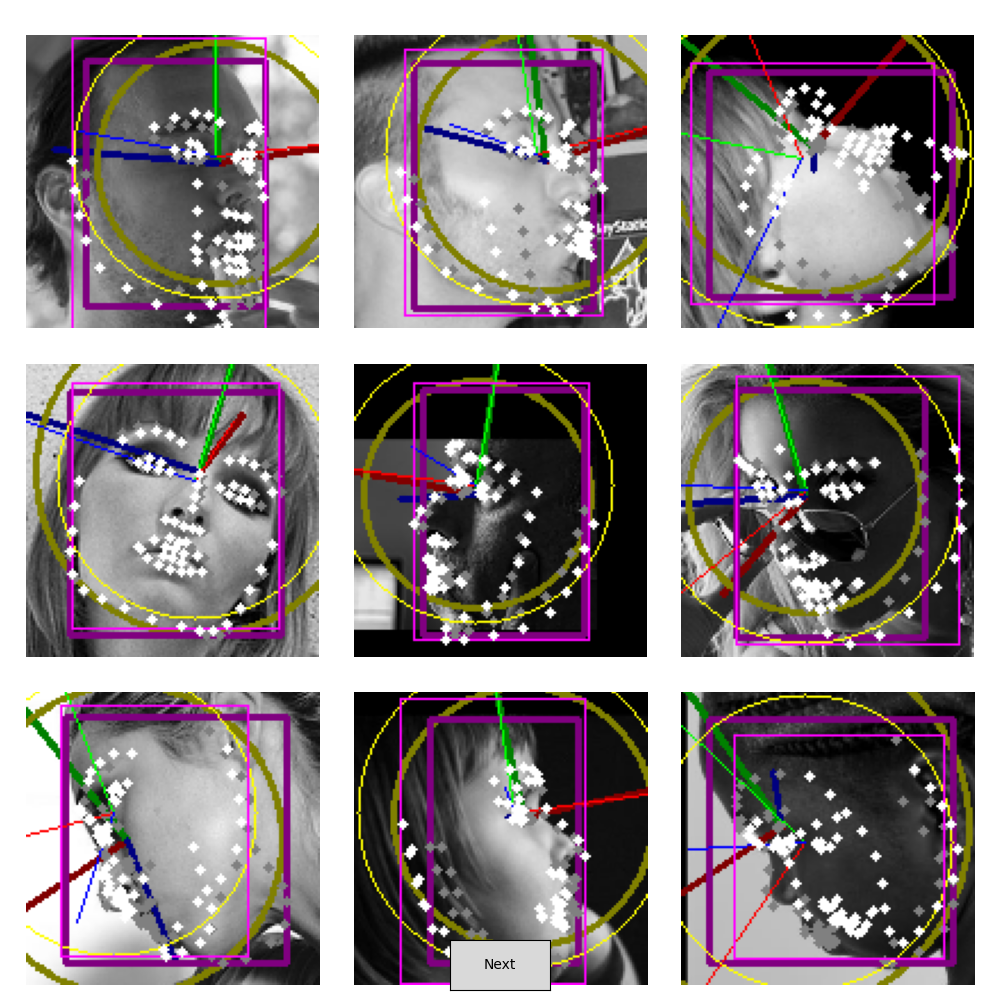

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7fc9e0ad5cd0>)

In [14]:
worst = train.k_worst_over_dataset(net, aflw_loader, pose_err, 9)
display_worst(worst)